In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
from source.tserie import TSerie
from source.read_ontario import read_ontario
from source.utils import commonWindows
from source.torch_utils import getContrastiveFeatures
from cuml.manifold import UMAP
from ccpca import CCPCA

VIS_PATH = 'visualizations'
SMOOTH = 8 # 8 -1 if you don't want to smooth the data otherwise the size of the smooth window
LOSS = 'SimCLR' # SupConLoss | SimCLR
MODE = 'subsequences' # subsequences - shape
# MODE = 'shape' # subsequences - shape
EPOCHS = 40
BATCH_SIZE = 128
ENC_SIZE = 8 # 8
POLLUTANTS = ['PM25', 'CO'] # ['NO', 'NOx', 'NO2', 'SO2', 'CO', 'O3', 'PM25']
CONV_FILTERS = [16, 32]
CONV_KERNELS = [7, 7]
UMAP_NEIGHBORS = 15
N_VIZ_SAMPLES = 600

/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Months case

In [2]:
windows_map = read_ontario(granularity='months', cache=True)
pollutans = POLLUTANTS
# windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

In [3]:
# windows_map['SO2'][13001]['2010-1'][0].shape
# windows_map
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

windows.shape

In [4]:
windows.shape
dates.shape

(1208,)

In [5]:
month_ids = np.array([date.month for date in dates])
year_ids = np.array([date.year for date in dates])


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, 13)}
years_map = {int(year) : str(year) for year in year_ids}

In [6]:
mts = TSerie(X=windows, y = station_ids)

if SMOOTH > 0:
    mts.smooth(window_size=SMOOTH)

if MODE == 'shape':
    mts.shapeNormalizization()
else:
    mts.minMaxNormalizization()


Loaded mts - N: 1208, T: 28, D: 2 
(1208, 2, 28)


In [7]:
from source.featlearn.autoencoder_lr import AutoencoderFL, DCEC, VAE_FL

cae = DCEC(mts.D, mts.T, feature_size=10, n_clusters=5)
# cae = VAE_FL(mts.D, mts.T, feature_size=10)

# cae.fit(mts.X, epochs=2000, batch_size=320)
cae.fit(mts.X, epochs=1000, batch_size=320, gamma=0)

Optimizer

/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[[0.19999263 0.19999914 0.20000489 0.19999762 0.20000574]
 [0.19999027 0.19999951 0.20000517 0.19999608 0.2000089 ]
 [0.19999434 0.19999948 0.20000422 0.19999854 0.20000339]
 ...
 [0.20000866 0.20000297 0.1999985  0.20000602 0.19998388]
 [0.20000556 0.20000292 0.1999993  0.20000426 0.19998798]
 [0.20000783 0.2000024  0.19999903 0.20000568 0.19998503]]

(1208, 5)

Epoch[1] Train loss    avg: 0.41223616898059845
Epoch[1] Train clust loss    avg: 0.0
Epoch[1] Rec loss    avg: 0.41223616898059845
Epoch[50] Train loss    avg: 0.009170733974315226
Epoch[50] Train clust loss    avg: 0.0
Epoch[50] Rec loss    avg: 0.009170733974315226
Epoch[100] Train loss    avg: 0.005529400892555714
Epoch[100] Train clust loss    avg: 0.0
Epoch[100] Rec loss    avg: 0.005529400892555714
Epoch[150] Train loss    avg: 0.004001312016043812
Epoch[150] Train clust loss    avg: 0.0
Epoch[150] Rec loss    avg: 0.004001312016043812
Epoch[200] Train loss    avg: 0.00327060412382707
Epoch[200] Train clust loss    avg: 0.0
Epoch[200] Rec loss    avg: 0.00327060412382707
Epoch[250] Train loss    avg: 0.0026455393235664815
Epoch[250] Train clust loss    avg: 0.0
Epoch[250] Rec loss    avg: 0.0026455393235664815
Epoch[300] Train loss    avg: 0.0024281443329527974
Epoch[300] Train clust loss    avg: 0.0
Epoch[300] Rec loss    avg: 0.0024281443329527974
Epoch[350] Train loss    avg:

In [8]:
from source.featlearn.autoencoder_lr import AutoencoderFL, DCEC

cae.fit(mts.X, epochs=1000, batch_size=320, gamma=100)
rec, mts.features, clusters = cae.encode(mts.X)
# rec, mts.features = cae.encode(mts.X)


Optimizer

/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[[0.3818271  0.07961477 0.03692399 0.31053442 0.19109975]
 [0.38319275 0.08013584 0.03727563 0.30797613 0.19141965]
 [0.37655562 0.0784105  0.03604427 0.31815183 0.19083782]
 ...
 [0.11189234 0.25693354 0.08192414 0.120948   0.42830193]
 [0.31295818 0.08271749 0.03678845 0.3642595  0.20327626]
 [0.00247819 0.12223317 0.85935533 0.00246115 0.01347211]]

(1208, 5)

Epoch[1] Train loss    avg: 3.220029443502426
Epoch[1] Train clust loss    avg: 3.2183145582675934
Epoch[1] Rec loss    avg: 0.0017148639308288693
Epoch[50] Train loss    avg: 15.260011672973633
Epoch[50] Train clust loss    avg: 15.25735092163086
Epoch[50] Rec loss    avg: 0.0026606714818626642
Epoch[100] Train loss    avg: 13.59116530418396
Epoch[100] Train clust loss    avg: 13.588785171508789
Epoch[100] Rec loss    avg: 0.0023800787748768926
Epoch[150] Train loss    avg: 12.855587244033813
Epoch[150] Train clust loss    avg: 12.85365605354309
Epoch[150] Rec loss    avg: 0.001931036909809336
Epoch[200] Train loss    avg: 12.439949750900269
Epoch[200] Train clust loss    avg: 12.438154935836792
Epoch[200] Rec loss    avg: 0.0017949835455510765
Epoch[250] Train loss    avg: 11.91125202178955
Epoch[250] Train clust loss    avg: 11.909328699111938
Epoch[250] Rec loss    avg: 0.00192343516391702
Epoch[300] Train loss    avg: 10.901151180267334
Epoch[300] Train clust loss    avg: 10.89936

In [9]:
# # clusters
preds = np.argmax(clusters, axis=1)
print(np.unique(preds, return_counts=True))

(array([0, 1, 2, 3, 4]), array([536,  26, 563,  73,  10]))


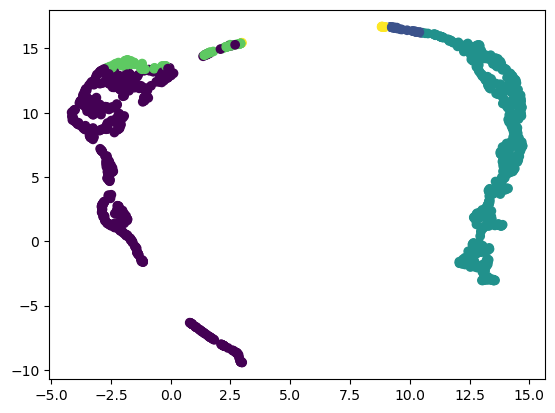

In [10]:
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
reducer = umap.UMAP(n_components=2, metric='euclidean')
# reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.1, metric='cosine')
# reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.1)
# reducer = TSNE(n_components=2, metric='euclidean')

# coords = reducer.fit_transform(mts.features, y = month_ids)
coords = reducer.fit_transform(mts.features)
plt.scatter(coords[:, 0], coords[:, 1], c=preds)
# plt.scatter(coords[:, 0], coords[:, 1])

In [11]:
import matplotlib.pyplot as plt

def plot1d(x, x2=None, x3=None, ylim=(-1, 1), save_file=""):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 3))
    steps = np.arange(x.shape[0])
    plt.plot(steps, x)
    if x2 is not None:
        plt.plot(steps, x2)
    if x3 is not None:
        plt.plot(steps, x3)
    plt.xlim(0, x.shape[0])
    # plt.ylim(ylim)
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file, "")
    else:
        plt.show()
    return

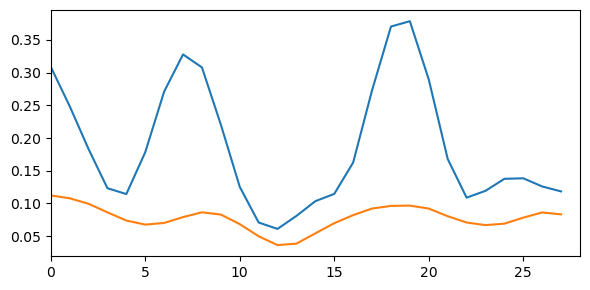

In [12]:
pos = 200
plot1d(mts.X[pos])

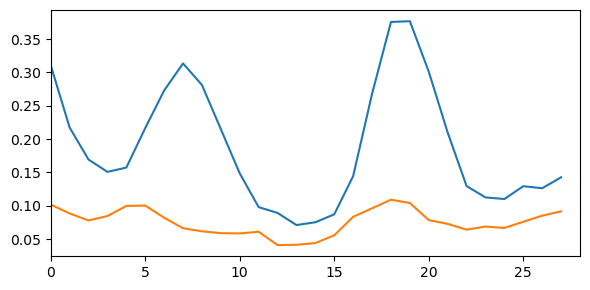

In [13]:
plot1d(rec[pos])